In [ ]:
import kagglehub

path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


# Plant Disease Detection

## Importing Libraries

In [ ]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [ ]:
dataset_root = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "valid")
test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test/'

## Part 1 - Data Preprocessing

In [ ]:
train_aug = ImageDataGenerator(
    rescale=1/255.0,
    fill_mode="nearest",
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
)

test_aug = ImageDataGenerator(
    rescale=1/255.0
)

cats = list(train_data.class_indices.keys())

train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

test_data = test_aug.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Part 2 - Building the Model (Transfer Learning)

### Loading Pretrained Model

In [ ]:
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

mbnet_v2.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Adding layers

In [ ]:
inputs = keras.Input(shape=input_shape)

x = mbnet_v2(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

model = Model(inputs=inputs, outputs=x)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Part 3 - Training the Model

### Compiling the Model

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)
model_checkpoint = ModelCheckpoint(filepath='/content/best.h5', monitor='accuracy', verbose=1, save_best_only=True)

### Training

In [ ]:
history = model.fit(
    train_data,
    epochs=30,
    steps_per_epoch=200,
    callbacks=[model_checkpoint, early_stopping_cb]
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7390 - loss: 0.9306
Epoch 1: accuracy improved from -inf to 0.76670, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 416ms/step - accuracy: 0.7391 - loss: 0.9301
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8205 - loss: 0.6127
Epoch 2: accuracy improved from 0.76670 to 0.83250, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 396ms/step - accuracy: 0.8205 - loss: 0.6125
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8592 - loss: 0.4859
Epoch 3: accuracy improved from 0.83250 to 0.85484, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 397ms/step - accuracy: 0.8592 - loss: 0.4859
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8504 - loss: 0.4757
Epoch 4: accuracy improved from 0.85484 to 0.85578, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 393ms/step - accuracy: 0.8505 - loss: 0.4756
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8609 - loss: 0.4443
Epoch 5: accuracy improved from 0.85578 to 0.86250, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 397ms/step - accuracy: 0.8609 - loss: 0.4443
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8730 - loss: 0.4071
Epoch 6: accuracy improved from 0.86250 to 0.86875, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 394ms/step - accuracy: 0.8730 - loss: 0.4071
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8866 - loss: 0.3539
Epoch 7: accuracy improved from 0.86875 to 0.88141, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 387ms/step - accuracy: 0.8866 - loss: 0.3540
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8853 - loss: 0.3554
Epoch 8: accuracy improved from 0.88141 to 0.89250, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 391ms/step - accuracy: 0.8854 - loss: 0.3553
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8853 - loss: 0.3494
Epoch 9: accuracy did not improve from 0.89250
200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 387ms/step - accuracy: 0.8853 - loss: 0.3493
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8881 - loss: 0.3543
Epoch 10: accuracy did not improve from 0.89250
200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 389ms/step - accuracy: 0.8881 - loss: 0.3542
Epoch 11/30
197/200 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.8938 - loss: 0.3267
Epoch 11: accuracy did not improve from 0.89250
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 381ms/step - accuracy: 0.8937 - loss: 0.3269
Epoch 12/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8989 - loss: 0.3251
Epoch 12: accuracy improved from 0.89250 to 0.89500, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 394ms/step - accuracy: 0.8989 - loss: 0.3251
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8996 - loss: 0.3019
Epoch 13: accuracy improved from 0.89500 to 0.90156, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 389ms/step - accuracy: 0.8996 - loss: 0.3018
Epoch 14/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8988 - loss: 0.3025
Epoch 14: accuracy did not improve from 0.90156
200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.8988 - loss: 0.3025
Epoch 15/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9041 - loss: 0.3043
Epoch 15: accuracy did not improve from 0.90156
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 381ms/step - accuracy: 0.9041 - loss: 0.3043
Epoch 16/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8979 - loss: 0.2974
Epoch 16: accuracy did not improve from 0.90156
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 382ms/step - accuracy: 0.8979 - loss: 0.2973
Epoch 17/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9075 - loss: 0.2895
Epoch 17: accuracy improved from 0.90156 to 0.90625, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 380ms/step - accuracy: 0.9075 - loss: 0.2895
Epoch 18/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9070 - loss: 0.2971
Epoch 18: accuracy improved from 0.90625 to 0.90969, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 380ms/step - accuracy: 0.9070 - loss: 0.2971
Epoch 19/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9129 - loss: 0.2769
Epoch 19: accuracy did not improve from 0.90969
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 383ms/step - accuracy: 0.9129 - loss: 0.2770
Epoch 20/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8965 - loss: 0.2914
Epoch 20: accuracy did not improve from 0.90969
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 378ms/step - accuracy: 0.8965 - loss: 0.2913
Epoch 21/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9112 - loss: 0.2736
Epoch 21: accuracy did not improve from 0.90969
200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 383ms/step - accuracy: 0.9112 - loss: 0.2737
Epoch 22/30
197/200 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - accuracy: 0.9092 - loss: 0.2689
Epoch 22: accuracy did not improve from 0.90969
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 378ms/step - accuracy: 0.9092 - loss: 0.2690
Epoch 23/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accur

200/200 ━━━━━━━━━━━━━━━━━━━━ 97s 387ms/step - accuracy: 0.9104 - loss: 0.2552
Epoch 24/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9014 - loss: 0.3086
Epoch 24: accuracy did not improve from 0.91206
200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 384ms/step - accuracy: 0.9014 - loss: 0.3085
Epoch 25/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9150 - loss: 0.2479
Epoch 25: accuracy did not improve from 0.91206
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 377ms/step - accuracy: 0.9149 - loss: 0.2480
Epoch 26/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9123 - loss: 0.2680
Epoch 26: accuracy did not improve from 0.91206
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 377ms/step - accuracy: 0.9123 - loss: 0.2681
Epoch 27/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9178 - loss: 0.2357
Epoch 27: accuracy improved from 0.91206 to 0.91844, saving model to /content/best2.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 381ms/step - accuracy: 0.9178 - loss: 0.2357
Epoch 28/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9148 - loss: 0.2529
Epoch 28: accuracy did not improve from 0.91844
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 374ms/step - accuracy: 0.9148 - loss: 0.2529
Epoch 29/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8988 - loss: 0.3030
Epoch 29: accuracy did not improve from 0.91844
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 377ms/step - accuracy: 0.8988 - loss: 0.3029
Epoch 30/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9021 - loss: 0.2823
Epoch 30: accuracy did not improve from 0.91844
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 380ms/step - accuracy: 0.9021 - loss: 0.2822


### Saving the Model

In [ ]:
model.save('model.h5')

In [ ]:
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

## Part 4 - Evaluating the Model

In [ ]:
model.evaluate(test_data)

550/550 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.9527 - loss: 0.1514


[0.2250492125749588, 0.9263601303100586]

### Classification Report

In [ ]:
test_data.reset()
preds = model.predict(test_data, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

550/550 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step
Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.92      0.94       504
                                 Apple___Black_rot       0.94      1.00      0.97       497
                          Apple___Cedar_apple_rust       0.97      0.97      0.97       440
                                   Apple___healthy       0.98      0.96      0.97       502
                               Blueberry___healthy       0.99      0.94      0.96       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.97      0.98       421
                 Cherry_(including_sour)___healthy       0.99      0.98      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.82      0.89       410
                       Corn_(maize)___Common_rust_       0.94      1.00      0.97       477
            

### Confussion Matrix

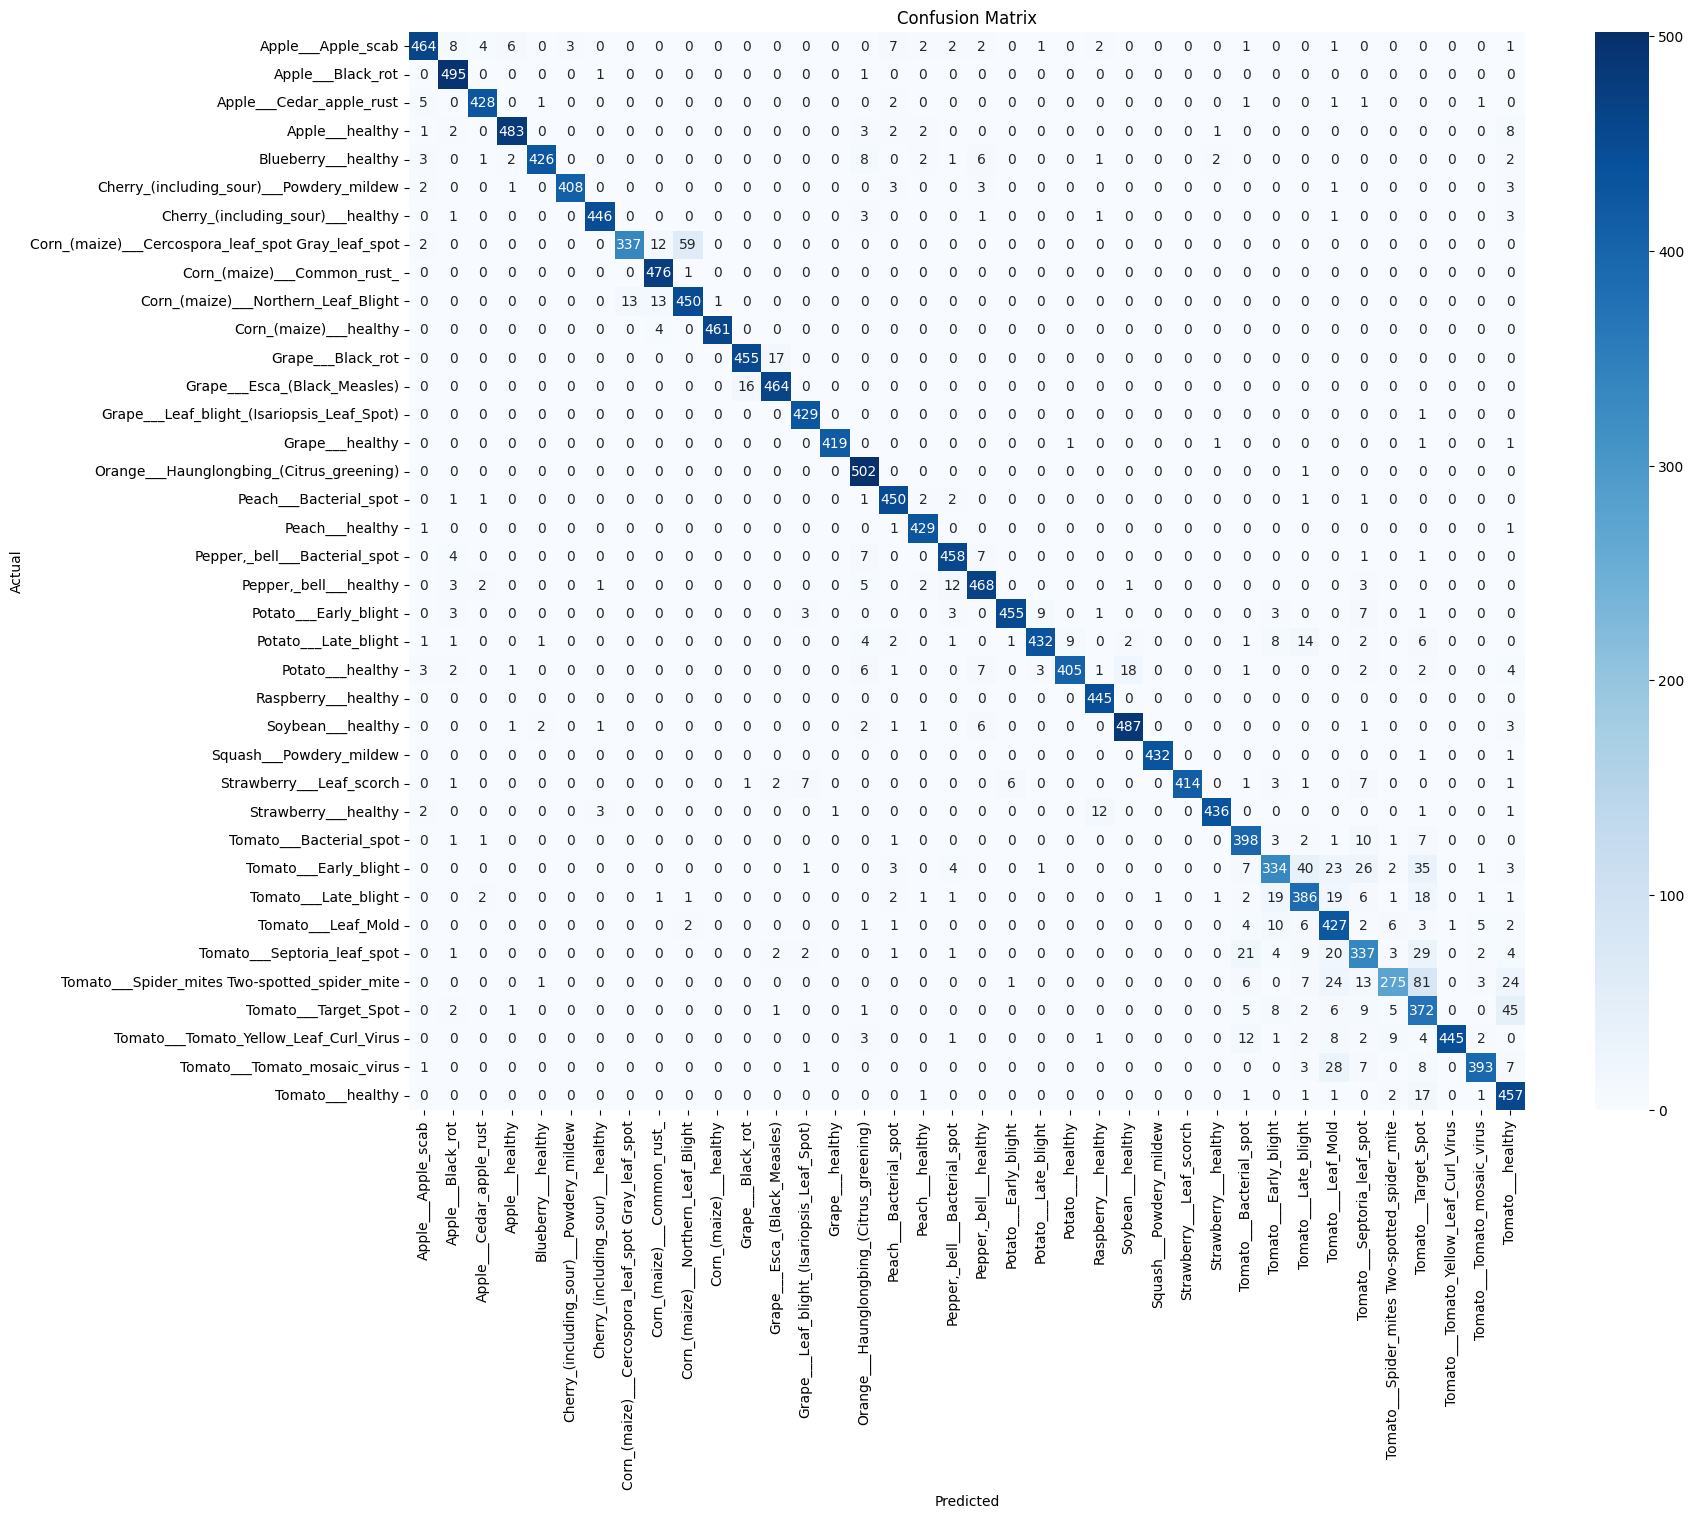

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 14))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Accuracy - Loss Curve

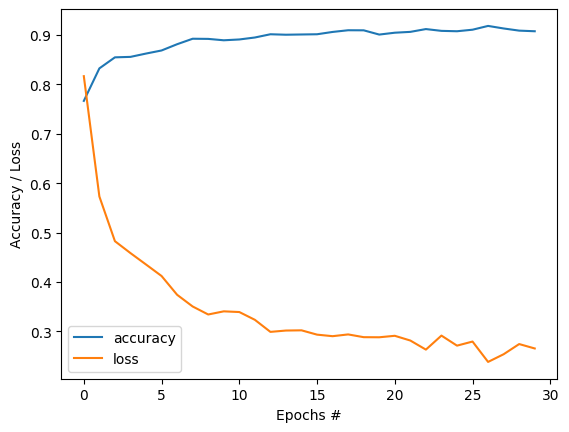

In [ ]:
hist = history.history

plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

plt.show()

## Part 5 - Predicting Test Cases

In [ ]:

with open('categories.json', 'r') as f:
    category_dict = json.load(f)

index_to_class = {v: k for k, v in category_dict.items()}

for filename in os.listdir(test_dir):
    img_path = os.path.join(test_dir, filename)
    img = image.load_img(img_path, target_size=(image_size, image_size))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0

    preds = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(preds[0])
    predicted_label = index_to_class[predicted_index]
    confidence = preds[0][predicted_index]

    print(f"{filename} -> {predicted_label} ({confidence * 100:.2f}%)")

TomatoEarlyBlight6.JPG -> Tomato___Early_blight (43.74%)
TomatoYellowCurlVirus4.JPG -> Tomato___Tomato_Yellow_Leaf_Curl_Virus (99.89%)
TomatoYellowCurlVirus6.JPG -> Tomato___Tomato_Yellow_Leaf_Curl_Virus (100.00%)
PotatoHealthy2.JPG -> Potato___healthy (82.72%)
TomatoYellowCurlVirus5.JPG -> Tomato___Tomato_Yellow_Leaf_Curl_Virus (99.94%)
PotatoEarlyBlight2.JPG -> Potato___Early_blight (98.87%)
TomatoYellowCurlVirus3.JPG -> Tomato___Tomato_Yellow_Leaf_Curl_Virus (96.86%)
TomatoEarlyBlight3.JPG -> Tomato___Target_Spot (48.53%)
CornCommonRust2.JPG -> Corn_(maize)___Common_rust_ (100.00%)
AppleScab3.JPG -> Apple___Apple_scab (99.44%)
TomatoEarlyBlight5.JPG -> Tomato___Target_Spot (54.77%)
TomatoHealthy2.JPG -> Tomato___healthy (99.45%)
CornCommonRust1.JPG -> Corn_(maize)___Common_rust_ (100.00%)
PotatoEarlyBlight4.JPG -> Potato___Early_blight (99.11%)
TomatoEarlyBlight2.JPG -> Tomato___Late_blight (61.63%)
TomatoYellowCurlVirus2.JPG -> Tomato___Tomato_Yellow_Leaf_Curl_Virus (100.00%)
CornC